In [25]:
import os, sys, pickle
import numpy as np
from collections import defaultdict
import torch

# Run from project root regardless of where the notebook is opened from
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')
_utils = os.path.join(os.getcwd(), 'utils')
if _utils not in sys.path:
    sys.path.insert(0, _utils)

device = torch.device(
    'cuda' if torch.cuda.is_available()
    else 'mps' if torch.backends.mps.is_available()
    else 'cpu'
)
print(f'Using device: {device}')

# --- Load test data ---
with open('prepared-data/test_tracks.pkl', 'rb') as f:
    test_tracks = pickle.load(f)
with open('prepared-data/test.pkl', 'rb') as f:
    test = pickle.load(f)
print(f'Loaded {len(test_tracks):,} test tracks')

# --- Load trained model ---
with open('saved-models/hybrid_cnn_mlp.pkl', 'rb') as f:
    saved = pickle.load(f)
nn_model     = saved['model'].to(device)
NN_THRESHOLD = saved['threshold']
nn_model.eval()
print(f'Loaded hybrid model  (threshold={NN_THRESHOLD:.3f})')

# --- Batch NN inference (test.pkl is aligned with test_tracks) ---
sequences_t = torch.FloatTensor(test['sequences']).permute(0, 2, 1)
summary_t   = torch.FloatTensor(test['summary'])
masks_t     = torch.FloatTensor(test['masks'])

nn_probs = []
BATCH = 512
with torch.no_grad():
    for i in range(0, len(sequences_t), BATCH):
        logits = nn_model(
            sequences_t[i:i+BATCH].to(device),
            summary_t  [i:i+BATCH].to(device),
            masks_t    [i:i+BATCH].to(device),
        )
        nn_probs.extend(torch.sigmoid(logits).cpu().numpy())
nn_probs = np.array(nn_probs)
nn_preds = (nn_probs >= NN_THRESHOLD).astype(int)
print(f'NN predicts {nn_preds.sum():,} pions / {len(nn_preds):,} ({100*nn_preds.mean():.1f}%)')

Using device: mps
Loaded 55,815 test tracks
Loaded hybrid model  (threshold=0.520)
NN predicts 15,769 pions / 55,815 (28.3%)


In [26]:
TARGET_EFFICIENCY = 0.247  # match cut-based selection efficiency

true_pion_labels = np.array([1 if PION_LABEL in t['particle'] else 0 for t in test_tracks])
n_true_pions = true_pion_labels.sum()

# Scan thresholds to find the one closest to the target efficiency
best_threshold, best_diff = 0.5, float('inf')
for thresh in np.linspace(0.01, 0.99, 5000):
    preds = (nn_probs >= thresh).astype(int)
    TP  = int(((preds == 1) & (true_pion_labels == 1)).sum())
    eff = TP / n_true_pions
    diff = abs(eff - TARGET_EFFICIENCY)
    if diff < best_diff:
        best_diff, best_threshold = diff, thresh

# Evaluate at matched threshold
nn_preds  = (nn_probs >= best_threshold).astype(int)
TP = int(((nn_preds == 1) & (true_pion_labels == 1)).sum())
FP = int(((nn_preds == 1) & (true_pion_labels == 0)).sum())
FN = int(((nn_preds == 0) & (true_pion_labels == 1)).sum())

matched_purity     = 100 * TP / (TP + FP)
matched_efficiency = 100 * TP / (TP + FN)

print(f"Matched threshold : {best_threshold:.4f}")
print(f"Efficiency        : {matched_efficiency:.1f}%  (target {100*TARGET_EFFICIENCY:.1f}%)")
print(f"Purity            : {matched_purity:.1f}%  (cut-based baseline: 72.4%)")
print(f"TP: {TP:,}  FP: {FP:,}  FN: {FN:,}")

Matched threshold : 0.7489
Efficiency        : 24.7%  (target 24.7%)
Purity            : 92.9%  (cut-based baseline: 72.4%)
TP: 3,766  FP: 290  FN: 11,479


In [27]:
PION_LABEL  = '$\\pi^{\\pm}$'
GAMMA_LABEL = '$\\gamma$'

def new_event():
    return {
        'cut_pi_plus':  0, 'pred_pi_plus': 0, 'true_pi_plus': 0,
        'cut_gamma':    0, 'true_gamma':   0,
        'cut_gamma_track_IDs':  [],
        'true_gamma_track_IDs': [],
        'cut_pi_zero':  0, 'true_pi_zero': 0,
    }

events      = defaultdict(new_event)
track_by_id = {t['track_ID']: t for t in test_tracks}

for i, track in enumerate(test_tracks):
    evt      = track['event_number']
    particle = track['particle']

    # --- True particle counts ---
    if PION_LABEL in particle:
        events[evt]['true_pi_plus'] += 1
    elif GAMMA_LABEL in particle:
        events[evt]['true_gamma'] += 1
        events[evt]['true_gamma_track_IDs'].append(track['track_ID'])

    chi2  = track['track_chi2/ndof_proton']
    score = track['track_score']

    # --- Cut-based π± selection ---
    if (chi2 > 61.2 and track['track_length'] > 27.1
            and score > 0.5 and 1.6 < track['dEdX_median'] < 2.8):
        events[evt]['cut_pi_plus'] += 1

    # --- NN π± prediction (applied to all tracks, independently of cuts) ---
    if nn_preds[i] == 1:
        events[evt]['pred_pi_plus'] += 1

    # --- Cut-based γ selection ---
    if (chi2 > 61.2 and score < 0.45
            and track['n_hits_collection'] > 80
            and track['b'] < 20
            and 3 < track['d'] < 90):
        events[evt]['cut_gamma'] += 1
        events[evt]['cut_gamma_track_IDs'].append(track['track_ID'])

print(f'Built event dictionary for {len(events):,} events')

Built event dictionary for 25,417 events


In [28]:
def shower_dir_vec(track):
    sd = track['shower_direction']
    return np.array([float(sd['x']), float(sd['y']), float(sd['z'])])

def pi0_candidate(t1, t2):
    """Return (mass_MeV, phi_deg), or (None, None) if E_c is missing/nan."""
    E1, E2 = t1.get('E_c'), t2.get('E_c')
    if E1 is None or E2 is None or np.isnan(E1) or np.isnan(E2):
        return None, None
    d1 = shower_dir_vec(t1)
    d2 = shower_dir_vec(t2)
    cos_phi = float(np.clip(
        np.dot(d1, d2) / (np.linalg.norm(d1) * np.linalg.norm(d2)), -1.0, 1.0
    ))
    phi_deg = np.degrees(np.arccos(cos_phi))
    mass    = np.sqrt(max(0.0, 2 * E1 * E2 * (1 - cos_phi)))
    return mass, phi_deg

PHI_CUT  = 60.0   # degrees
MASS_CUT = 225.0  # MeV

for evt_data in events.values():
    for id_key, zero_key in [('cut_gamma_track_IDs',  'cut_pi_zero'),
                              ('true_gamma_track_IDs', 'true_pi_zero')]:
        if len(evt_data[id_key]) == 2:
            t1 = track_by_id[evt_data[id_key][0]]
            t2 = track_by_id[evt_data[id_key][1]]
            mass, phi = pi0_candidate(t1, t2)
            if mass is not None and phi < PHI_CUT and mass < MASS_CUT:
                evt_data[zero_key] += 1

print('Pi0 reconstruction complete')

Pi0 reconstruction complete


In [29]:
totals = {k: 0 for k in new_event()
          if k not in ('cut_gamma_track_IDs', 'true_gamma_track_IDs')}
for evt_data in events.values():
    for k in totals:
        totals[k] += evt_data[k]

print(f"{'='*52}")
print(f"  Topology-level summary  ({len(events):,} events)")
print(f"{'='*52}")
print(f"  {'Quantity':<25} {'Cut':>8}  {'NN pred':>8}  {'True':>8}")
print(f"  {'-'*44}")
print(f"  {'Charged pions (pi+)':<25} {totals['cut_pi_plus']:>8,}  {totals['pred_pi_plus']:>8,}  {totals['true_pi_plus']:>8,}")
print(f"  {'Photons (gamma)':<25} {totals['cut_gamma']:>8,}  {'---':>8}  {totals['true_gamma']:>8,}")
print(f"  {'Neutral pions (pi0)':<25} {totals['cut_pi_zero']:>8,}  {'---':>8}  {totals['true_pi_zero']:>8,}")
print(f"{'='*52}")

events = dict(events)

  Topology-level summary  (25,417 events)
  Quantity                       Cut   NN pred      True
  --------------------------------------------
  Charged pions (pi+)          5,197     4,056    15,245
  Photons (gamma)              2,780       ---    15,552
  Neutral pions (pi0)             23       ---       574


In [30]:
cuts = [
    ("chi²/ndof_p > 61.2",      lambda t: t['track_chi2/ndof_proton'] > 61.2),
    ("track length > 27.1",     lambda t: t['track_length'] > 27.1),
    ("track score > 0.5",       lambda t: t['track_score'] > 0.5),
    ("1.6 < dEdX median < 2.8", lambda t: 1.6 < t['dEdX_median'] < 2.8),
]

print(f"  {'Cut added':<28} {'Purity':>8}  {'Efficiency':>10}  {'TP':>7}  {'FP':>7}  {'FN':>7}")
print(f"  {'-'*72}")

for n_cuts in range(0, len(cuts) + 1):
    TP = FP = FN = 0
    for track in test_tracks:
        is_true_pion = PION_LABEL in track['particle']
        is_cut_pion  = all(fn(track) for _, fn in cuts[:n_cuts]) if n_cuts > 0 else True

        if   is_true_pion and     is_cut_pion: TP += 1
        elif is_true_pion and not is_cut_pion: FN += 1
        elif not is_true_pion and is_cut_pion: FP += 1

    purity     = 100 * TP / (TP + FP) if (TP + FP) > 0 else 0
    efficiency = 100 * TP / (TP + FN) if (TP + FN) > 0 else 0
    label      = "(no cuts)" if n_cuts == 0 else cuts[n_cuts - 1][0]
    print(f"  {label:<28} {purity:>7.1f}%  {efficiency:>9.1f}%  {TP:>7,}  {FP:>7,}  {FN:>7,}")

  Cut added                      Purity  Efficiency       TP       FP       FN
  ------------------------------------------------------------------------
  (no cuts)                       27.3%      100.0%   15,245   40,570        0
  chi²/ndof_p > 61.2              36.5%       95.5%   14,552   25,266      693
  track length > 27.1             50.6%       55.1%    8,399    8,193    6,846
  track score > 0.5               69.7%       52.1%    7,941    3,458    7,304
  1.6 < dEdX median < 2.8         72.4%       24.7%    3,764    1,433   11,481


In [31]:
from collections import Counter

def classify_topology(pi_plus, gamma, pi_zero):
    """Return topology label for a given (pi+, gamma, pi0) count."""
    if pi_plus == 0 and gamma == 0:
        return 'absorption'
    if pi_plus == 0 and ((gamma == 2 and pi_zero == 1) or gamma == 1):
        return 'charge_exchange'
    if pi_plus == 1 and gamma == 0:
        return 'single_pion_production'
    if pi_plus > 1 or (pi_plus > 0 and gamma == 2 and pi_zero == 1) or gamma == 2:
        return 'pion_production'
    return 'other'


absorption_events        = {'pred': 0, 'cut': 0, 'true': 0}
charge_exchange_events   = {'pred': 0, 'cut': 0, 'true': 0}
single_pion_events       = {'pred': 0, 'cut': 0, 'true': 0}
pion_production_events   = {'pred': 0, 'cut': 0, 'true': 0}

topology_map = {
    'absorption':             absorption_events,
    'charge_exchange':        charge_exchange_events,
    'single_pion_production': single_pion_events,
    'pion_production':        pion_production_events,
}

# Joint (true_topo, reco_topo) counts for confusion matrices
joint_cut  = Counter()
joint_pred = Counter()

for evt_data in events.values():
    pred_topo = classify_topology(evt_data['pred_pi_plus'],
                                  evt_data['cut_gamma'],
                                  evt_data['cut_pi_zero'])
    cut_topo  = classify_topology(evt_data['cut_pi_plus'],
                                  evt_data['cut_gamma'],
                                  evt_data['cut_pi_zero'])
    true_topo = classify_topology(evt_data['true_pi_plus'],
                                  evt_data['true_gamma'],
                                  evt_data['true_pi_zero'])

    if pred_topo in topology_map:
        topology_map[pred_topo]['pred'] += 1
    if cut_topo in topology_map:
        topology_map[cut_topo]['cut'] += 1
    if true_topo in topology_map:
        topology_map[true_topo]['true'] += 1

    joint_cut [(true_topo, cut_topo)]  += 1
    joint_pred[(true_topo, pred_topo)] += 1

print(f"{'='*58}")
print(f"  {'Topology':<28} {'Pred':>8}  {'Cut':>8}  {'True':>8}")
print(f"  {'-'*54}")
for name, d in [
    ('Absorption',              absorption_events),
    ('Charge exchange',         charge_exchange_events),
    ('Single pion production',  single_pion_events),
    ('Pion production',         pion_production_events),
]:
    print(f"  {name:<28} {d['pred']:>8,}  {d['cut']:>8,}  {d['true']:>8,}")
print(f"{'='*58}")

  Topology                         Pred       Cut      True
  ------------------------------------------------------
  Absorption                     18,856    17,820     1,020
  Charge exchange                 2,571     2,525     9,398
  Single pion production          3,746     4,729    10,193
  Pion production                   138       193     2,813


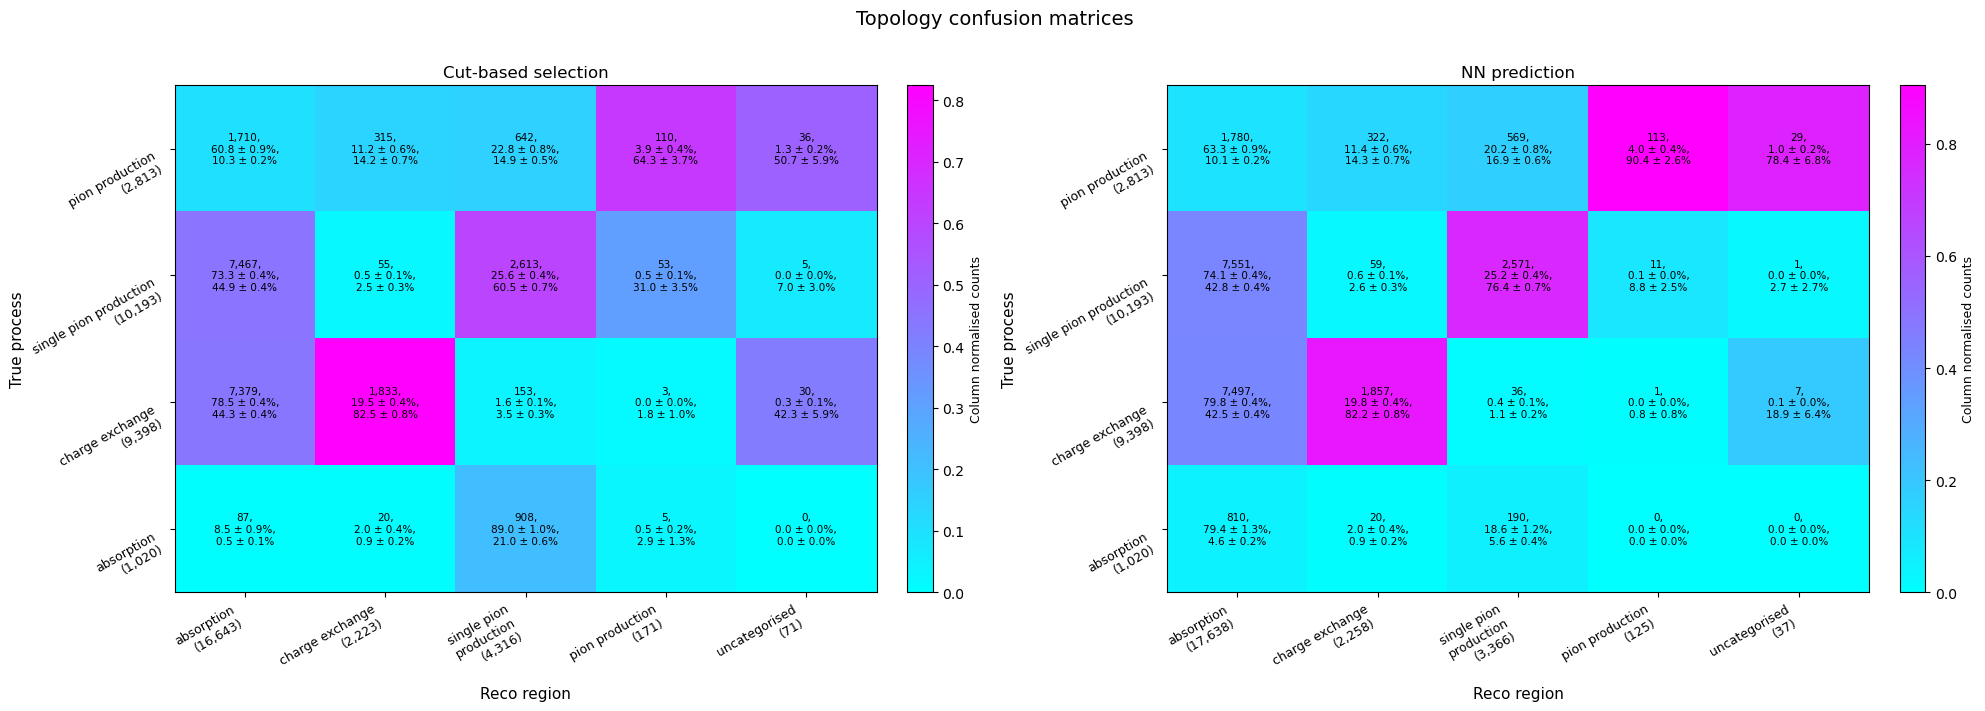

In [32]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Row order (top→bottom on y-axis), column order (left→right on x-axis)
TRUE_ORDER = ['pion_production', 'single_pion_production', 'charge_exchange', 'absorption']
RECO_ORDER = ['absorption', 'charge_exchange', 'single_pion_production', 'pion_production', 'other']

TRUE_LABELS = ['pion production', 'single pion production', 'charge exchange', 'absorption']
RECO_LABELS = ['absorption', 'charge exchange', 'single pion\nproduction', 'pion production', 'uncategorised']


def binomial_unc(count, total):
    if total == 0:
        return 0.0
    p = count / total
    return 100 * (p * (1 - p) / total) ** 0.5


def plot_topology_matrix(joint, reco_label, ax):
    N_true = len(TRUE_ORDER)
    N_reco = len(RECO_ORDER)

    matrix = np.array([
        [joint[(t, r)] for r in RECO_ORDER]
        for t in TRUE_ORDER
    ])

    row_totals = matrix.sum(axis=1)
    col_totals = matrix.sum(axis=0)

    col_norm = matrix / col_totals[np.newaxis, :].clip(min=1)

    im = ax.imshow(col_norm, cmap='cool', aspect='auto', vmin=0, vmax=col_norm.max())

    for i in range(N_true):
        for j in range(N_reco):
            n = matrix[i, j]
            row_pct = 100 * n / row_totals[i] if row_totals[i] > 0 else 0.0
            col_pct = 100 * n / col_totals[j] if col_totals[j] > 0 else 0.0
            row_unc = binomial_unc(n, row_totals[i])
            col_unc = binomial_unc(n, col_totals[j])
            ax.text(j, i,
                    f'{n:,},\n{row_pct:.1f} ± {row_unc:.1f}%,\n{col_pct:.1f} ± {col_unc:.1f}%',
                    ha='center', va='center', fontsize=7.5)

    reco_tick_labels = [f'{lbl}\n({col_totals[j]:,})' for j, lbl in enumerate(RECO_LABELS)]
    true_tick_labels = [f'{lbl}\n({row_totals[i]:,})' for i, lbl in enumerate(TRUE_LABELS)]

    ax.set_xticks(range(N_reco))
    ax.set_xticklabels(reco_tick_labels, rotation=30, ha='right', fontsize=9)
    ax.set_yticks(range(N_true))
    ax.set_yticklabels(true_tick_labels, rotation=30, va='top', fontsize=9)
    ax.set_xlabel('Reco region', fontsize=11)
    ax.set_ylabel('True process', fontsize=11)
    ax.set_title(reco_label, fontsize=12)

    return im


fig, axes = plt.subplots(1, 2, figsize=(20, 7))

im_cut  = plot_topology_matrix(joint_cut,  'Cut-based selection',   axes[0])
im_pred = plot_topology_matrix(joint_pred, 'NN prediction',          axes[1])

for ax, im in zip(axes, [im_cut, im_pred]):
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Column normalised counts', fontsize=9)

plt.suptitle('Topology confusion matrices', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()